In [1]:
%pylab inline

import os
from styles import slides
from astropy.io import fits
from tools.EW import equivalent_width
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
rdir = os.path.expandvars("$HOME/Research/photometric-ew")

EWs = pd.read_csv("{}/data/photo-speclines.csv".format(rdir), index_col="FITS")
EWs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34462 entries, spSpec-51602-0266-012.fit.gz to spSpec-54650-2833-231.fit.gz
Data columns (total 50 columns):
OVI         0 non-null float64
Ly_alpha    0 non-null float64
NV          0 non-null float64
OI1306      0 non-null float64
CII1335     0 non-null float64
SiIV+OIV    0 non-null float64
CIV         0 non-null float64
HeII        0 non-null float64
OIII1665    0 non-null float64
AlIII       0 non-null float64
CIII        0 non-null float64
CII2326     0 non-null float64
NeIV        0 non-null float64
MgII        0 non-null float64
NeV3347     0 non-null float64
NeV3427     0 non-null float64
OII3727     33204 non-null float64
OII3730     33227 non-null float64
H_eta       34409 non-null float64
H_zeta      34430 non-null float64
HeI         34435 non-null float64
CaIIK       34432 non-null float64
CaIIH       34447 non-null float64
SII         34458 non-null float64
H_delta     34458 non-null float64
G           34461 non-null float64


In [3]:
fits_names = EWs.index.values
ur = EWs.u-EWs.r
mask = ur<2.22

ew_neb_mine = []
ew_neb_sdss = []
redshift = []
for i in xrange(500):
    with fits.open("{}/data/fits/{}".format(rdir, fits_names[mask][i])) as f:
        wlen = array([10**(f[0].header["COEFF0"]+f[0].header["COEFF1"]*j) for j in xrange(f[0].header["NAXIS1"])])
        #wlen /= 1.0 + 2.735182E-4 + 131.4182 / wlen**2 + 2.76249E8 / wlen**4
        flux = f[0].data[0]*1e-17
        sed_ = column_stack((wlen,flux))
        #print f[2].data["wave"][36]/(f[0].header["Z"]+1), f[2].data["restWave"][36]
        #ew_neb_mine += [equivalent_width(sed_, (6564.61/(1.0 + 2.735182E-4 + 131.4182 / f[2].data["Wave"][36]**2 + 2.76249E8 / f[2].data["Wave"][36]**4),), (100,))[0]]
        ew_neb_mine += [equivalent_width(sed_, (6564.61*(f[0].header["Z"]+1),), (20*(f[0].header["Z"]+1),))[0]]
        ew_neb_sdss += [abs(EWs.H_alpha.values[mask][i])]
        redshift += [f[0].header["Z"]]

ew_neb_mine = array(ew_neb_mine)
ew_neb_sdss = array(ew_neb_sdss)
redshift = array(redshift)

Text(0,0.5,u'$N$')

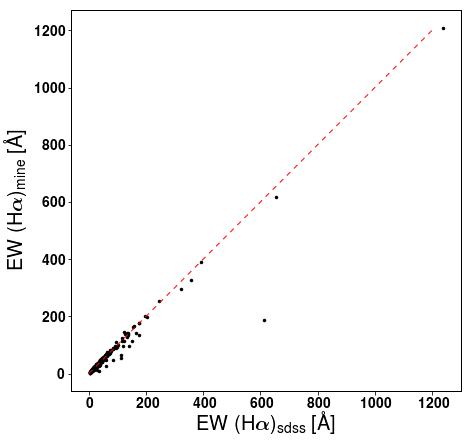

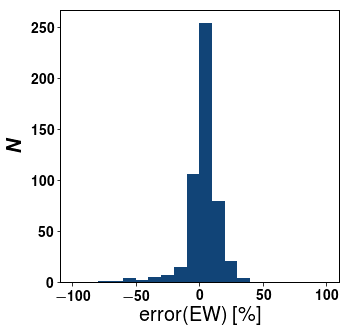

In [4]:
figure(figsize=(7,7))
plot(ew_neb_sdss, ew_neb_mine, ".k", mew=0)
gca().set_aspect("equal")
plot([0,1200],[0,1200], ls=(0,(5,5)), color="r", lw=1.0)
xlabel(r"EW (H$\alpha$)$_\text{sdss}$ [\AA]")
ylabel(r"EW (H$\alpha$)$_\text{mine}$ [\AA]")


figure(figsize=(5,5))
hist((ew_neb_mine-ew_neb_sdss)*100./ew_neb_sdss, 20, range=(-100,+100))
xlabel(r"error(EW) [\%]")
ylabel(r"$N$")